In [0]:
!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=ae98ba3028c872bca11bc9622da66df2f0011d1765a21d1b68c424b8914faf60
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Kaggle API 1.5.6


In [3]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

 99% 1.67G/1.69G [00:17<00:00, 122MB/s]
100% 1.69G/1.69G [00:17<00:00, 103MB/s]
Archive:  plant-seedlings-classification.zip
  inflating: sample_submission.csv   
  inflating: test/0021e90e4.png      
  inflating: test/003d61042.png      
  inflating: test/007b3da8b.png      
  inflating: test/0086a6340.png      
  inflating: test/00c47e980.png      
  inflating: test/00d090cde.png      
  inflating: test/00ef713a8.png      
  inflating: test/01291174f.png      
  inflating: test/026716f9b.png      
  inflating: test/02cfeb38d.png      
  inflating: test/03566743d.png      
  inflating: test/03a2ee656.png      
  inflating: test/03e322a29.png      
  inflating: test/03ef36742.png      
  inflating: test/043449b0b.png      
  inflating: test/0437393b1.png      
  inflating: test/04814f36d.png      
  inflating: test/05341a8a6.png      
  inflating: test/060450d79.png      
  inflating: test/060f1dc84.png      
  inflating: test/0625f063b.png      
  inflating: test/063363305.png      
 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import cv2
import math
import itertools


from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE


%tensorflow_version 1.x
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adadelta, SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 70
IMG_WIDTH = 70
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

lwr_hsv = (25,40,50)
upr_hsv = (75,255,255)

# Data Loading

In [6]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    trainImg.append(rez_img.flatten())
    
    trainLabel.append(imag.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 14700)
(4750, 1)


In [9]:
#even up the classes with SMOTE
smt = SMOTE()
trainImg_S, trainLabel_S = smt.fit_sample(trainImg, trainLabel)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

In [10]:
trainImg = trainImg_S.reshape(len(trainLabel_S),IMG_WIDTH, IMG_HEIGHT,3)
trainLabel = pd.DataFrame(trainLabel_S)
print(trainImg.shape)
print(trainLabel.shape)

(7848, 70, 70, 3)
(7848, 1)


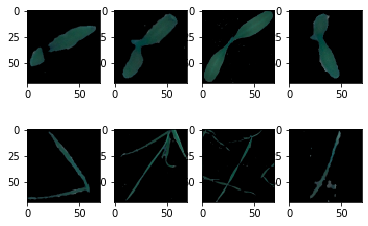

In [11]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

# Cleaning data

## Normalize Input & Categorize Labels

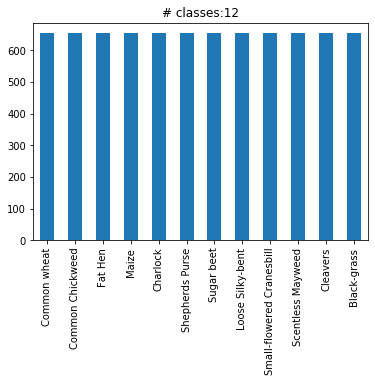

In [12]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))


In [0]:
trainImg = trainImg / 255

# Model Definition

## Data splitting and Generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

## Model Architecture

In [19]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', input_shape=(IMG_WIDTH, IMG_WIDTH, 3)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=64,kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))


model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(BatchNormalization(axis=-1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 70, 70, 64)        4864      
_________________________________________________________________
batch_normalization_10 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 70, 70, 64)        102464    
_________________________________________________________________
batch_normalization_11 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 70, 70, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 64)       

In [0]:
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="weight-cnn-nofilter.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="weights-cnn-nofilter.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

BATCH_SIZE = 16

In [21]:
# fit model
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                           epochs=20,
                           validation_data=(X_valid, y_valid), 
                           steps_per_epoch=(10 * X_train.shape[0]) / BATCH_SIZE,
                           callbacks=[checkpoint, learning_rate_reduction, checkpoint_all])


Epoch 1/20
1570/3923 [===========>..................] - ETA: 2s - loss: 0.6672 - acc: 0.7694
Epoch 00001: val_acc improved from -inf to 0.76943, saving model to weight-cnn-nofilter.best_01-0.77.hdf5

Epoch 00001: saving model to weights-cnn-nofilter.last_auto4.hdf5
3924/3923 [==============================] - 131s 33ms/step - loss: 1.3171 - acc: 0.5515 - val_loss: 0.6848 - val_acc: 0.7694
Epoch 2/20
1568/3923 [==========>...................] - ETA: 1s - loss: 0.5187 - acc: 0.8189
Epoch 00002: val_acc improved from 0.76943 to 0.81783, saving model to weight-cnn-nofilter.best_02-0.82.hdf5

Epoch 00002: saving model to weights-cnn-nofilter.last_auto4.hdf5
3924/3923 [==============================] - 127s 32ms/step - loss: 0.7282 - acc: 0.7660 - val_loss: 0.5500 - val_acc: 0.8178
Epoch 3/20
1520/3923 [==========>...................] - ETA: 1s - loss: 0.3626 - acc: 0.8724
Epoch 00003: val_acc improved from 0.81783 to 0.87452, saving model to weight-cnn-nofilter.best_03-0.87.hdf5

Epoch 0000

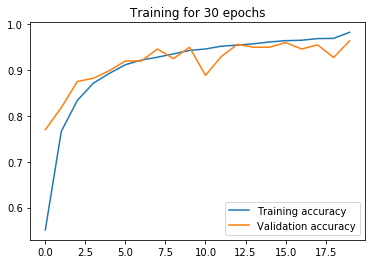

In [22]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training for ' +str(30)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [23]:
  model.load_weights("weight-cnn-nofilter.best_20-0.96.hdf5")

print("Train accuracy", model.evaluate(X_train, y_train))  # Evaluate on train set
print("Validation accuracy", model.evaluate(X_valid, y_valid))  # Evaluate on test set

6278/6278 [==============================] - 3s 534us/sample - loss: 0.0359 - acc: 0.9868
Train accuracy [0.0358825044925424, 0.9867792]
1570/1570 [==============================] - 1s 519us/sample - loss: 0.1175 - acc: 0.9631
Validation accuracy [0.11751579321493769, 0.96305734]


# Confusion Matrix

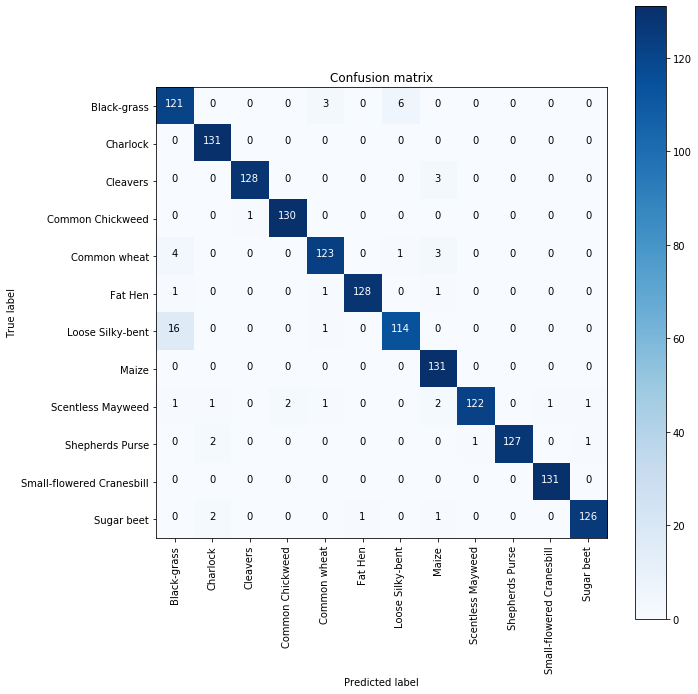

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_valid, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 


# Predicting on Test Set

In [25]:
path =  TEST_DIRECTORY + '/*.png'
files = glob(path)

testImg = []
testId = []
num = len(files)

# Obtain images and resizing, obtain labels
for imag in files:
    testId.append(imag.split('/')[-1])  # Images id's
    
    img = cv2.imread(imag)

    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,lwr_hsv,upr_hsv)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new_img = np.zeros_like(img,np.uint8)
    new_img[boolean] = img[boolean]
    res_img = new_img


    rez_img = cv2.resize(res_img, dsize =(IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
    rez_img = rez_img.reshape(IMG_WIDTH, IMG_HEIGHT, 3)
    testImg.append(rez_img)
    
testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)

(794, 70, 70, 3)


In [0]:
testImg = testImg / 255

In [0]:
pred = model.predict(testImg)

In [0]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)